<a href="https://colab.research.google.com/github/rivaldo1403/Model-yolo-untuk-dataset-kupu-kupu/blob/main/DEEPL_YOLOv5_UAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
import shutil
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from PIL import Image
import yaml

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Set the home directory to Colab working directory
HOME = os.getcwd()
print(HOME)

/content


#Augmentasi data

In [4]:
# # Define the dataset path in your Google Drive
# dataset_path = '/content/drive/My Drive/dataset/dataset_cnn'  # Change to the correct folder
# output_path = '/content/drive/My Drive/augmented_dataset'

In [5]:
# # Buat folder output jika belum ada
# os.makedirs(output_path, exist_ok=True)

# # Fungsi untuk melakukan augmentasi gambar
# def augment_images(folder_path, output_folder, target_count=150):
#     # Dapatkan semua file gambar dalam folder
#     images = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

#     # Salin gambar asli ke folder output
#     for image in images:
#         shutil.copy(os.path.join(folder_path, image), os.path.join(output_folder, image))

#     # Hitung jumlah gambar yang ada setelah penyalinan
#     current_count = len(images)
#     print(f"Current count in {output_folder}: {current_count}")

#     # Jika jumlah gambar kurang dari target, lakukan augmentasi
#     if current_count < target_count:
#         additional_needed = target_count - current_count
#         print(f"Augmenting {additional_needed} images in {folder_path}")

#         # Lakukan rotasi untuk augmentasi
#         for i in range(additional_needed):
#             for image in images:
#                 img_path = os.path.join(folder_path, image)
#                 img = Image.open(img_path)

#                 # Rotasi gambar dengan sudut yang berbeda
#                 rotated_img = img.rotate(i * (360 / additional_needed))  # Rotasi dengan sudut yang berbeda
#                 rotated_img_name = f'aug_{i}_{image}'

#                 # Cek nama file untuk karakter yang tidak valid
#                 rotated_img_name = rotated_img_name.replace(":", "_").replace("/", "_")

#                 # Simpan gambar yang telah dirotasi
#                 try:
#                     rotated_img.save(os.path.join(output_folder, rotated_img_name))
#                     print(f"Saved augmented image: {rotated_img_name}")
#                 except Exception as e:
#                     print(f"Error saving image {rotated_img_name}: {e}")

#                 # Cek jika sudah mencapai target
#                 if len(os.listdir(output_folder)) >= target_count:
#                     print(f"Reached target count of {target_count} in {output_folder}")
#                     return

# # Dapatkan semua subfolder dalam dataset
# subfolders = [f.path for f in os.scandir(dataset_path) if f.is_dir()]

# # Proses setiap subfolder
# for subfolder in subfolders:
#     folder_name = os.path.basename(subfolder)
#     output_folder = os.path.join(output_path, folder_name)
#     os.makedirs(output_folder, exist_ok=True)

#     # Lakukan augmentasi gambar
#     augment_images(subfolder, output_folder)

# print("Augmentasi selesai!")

In [6]:
# Define the dataset path in your Google Drive
dataset_path = '/content/drive/My Drive/augmented_dataset'  # Ganti dengan folder augmentasi
output_path = '/content'  # Simpan di Google Colab

In [7]:
# Create the necessary folder structure for the dataset
def create_folder_structure(base_path):
    folders = [
        'data/train/images', 'data/train/labels',
        'data/val/images', 'data/val/labels',
        'data/test/images', 'data/test/labels'
    ]
    for folder in folders:
        os.makedirs(os.path.join(base_path, folder), exist_ok=True)

create_folder_structure(output_path)

In [8]:
# Process the dataset and organize files
def process_dataset(dataset_path, output_path):
    # Kelas kupu-kupu
    classes = ['kupu_batik_cap', 'kupu_harimau_kuning_hijau', 'kupu_hijau_biru',
               'kupu_jarak', 'kupu_jojo', 'kupu_pantat_merah',
               'kupu_raja_helena', 'kupu_raja_limau']

    # Mengumpulkan file gambar dari semua folder
    image_files = []
    for class_name in classes:
        class_folder = os.path.join(dataset_path, class_name)

        # Cek jika folder kelas ada
        if os.path.exists(class_folder):
            files = [(f, class_name) for f in os.listdir(class_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if files:  # Hanya tambahkan jika ada file
                image_files.extend(files)
            else:
                print(f"No images found in {class_folder}.")
        else:
            print(f"Folder {class_folder} does not exist. Skipping...")

    # Cek jika tidak ada gambar yang ditemukan
    if not image_files:
        print("No images found in any class folders. Exiting...")
        return

    # Split the dataset into train, val, and test sets
    train_val, test = train_test_split(image_files, test_size=0.1, random_state=42)  # 10% untuk test
    train, val = train_test_split(train_val, test_size=0.2222, random_state=42)  # 20% dari 90% untuk val

    # Create output directories once
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_path, f'data/{split}/images'), exist_ok=True)
        os.makedirs(os.path.join(output_path, f'data/{split}/labels'), exist_ok=True)

    # Process and move files
    for split, files in [('train', train), ('val', val), ('test', test)]:
        for file_name, class_name in files:
            # Define source and destination paths for the image
            src_img = os.path.join(dataset_path, class_name, file_name)
            dst_img = os.path.join(output_path, f'data/{split}/images', file_name)

            shutil.copy(src_img, dst_img)

            # Generate YOLO label for the class
            class_id = classes.index(class_name)
            label_file = os.path.splitext(file_name)[0] + '.txt'
            dst_label = os.path.join(output_path, f'data/{split}/labels', label_file)

            # Write YOLO label (full image represents the class, no bounding box)
            with open(dst_label, 'w') as label_out:
                # The format is "class_id center_x center_y width height" (centered, full image)
                label_out.write(f"{class_id} 0.5 0.5 1.0 1.0\n")

    # Create data.yaml for YOLO
    yaml_content = {
        'train': f'{output_path}/data/train/images',
        'val': f'{output_path}/data/val/images',
        'test': f'{output_path}/data/test/images',
        'nc': len(classes),  # Jumlah kelas
        'names': classes  # Nama kelas sesuai dataset Anda
    }

    # Save the data.yaml file with corrected structure
    yaml_file_path = os.path.join(output_path, 'data.yaml')  # Simpan di output_path
    with open(yaml_file_path, 'w') as yaml_file:
        yaml.dump(yaml_content, yaml_file, default_flow_style=False)

    print(f"Data YAML saved at: {yaml_file_path}")

# Example usage
process_dataset(dataset_path, output_path)
print("Dataset preparation completed.")

Data YAML saved at: /content/data.yaml
Dataset preparation completed.


In [9]:
!pip install albumentations==1.4

In [10]:
!pip uninstall -y tensorflow tensorboard


In [11]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt


fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5


In [12]:
from yolov5 import train

!python train.py --img 640 --batch 16 --epochs 15 --data /content/data.yaml --weights yolov5n.pt --project /content/runs --name yolov5_detect


wandb: W&B disabled due to login timeout.


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5n.pt, cfg=, data=/content/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=15, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=/content/runs, name=yolov5_detect, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifac

In [13]:
import shutil
from google.colab import files

# Path dari folder yang ingin di-zip
folder_path = '/content/runs'

# Buat file zip dari folder tersebut di lokasi terpisah
shutil.make_archive('/content/runs_backup', 'zip', folder_path)

# Download file zip yang sudah dibuat
files.download('/content/runs_backup.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
from IPython.display import Image

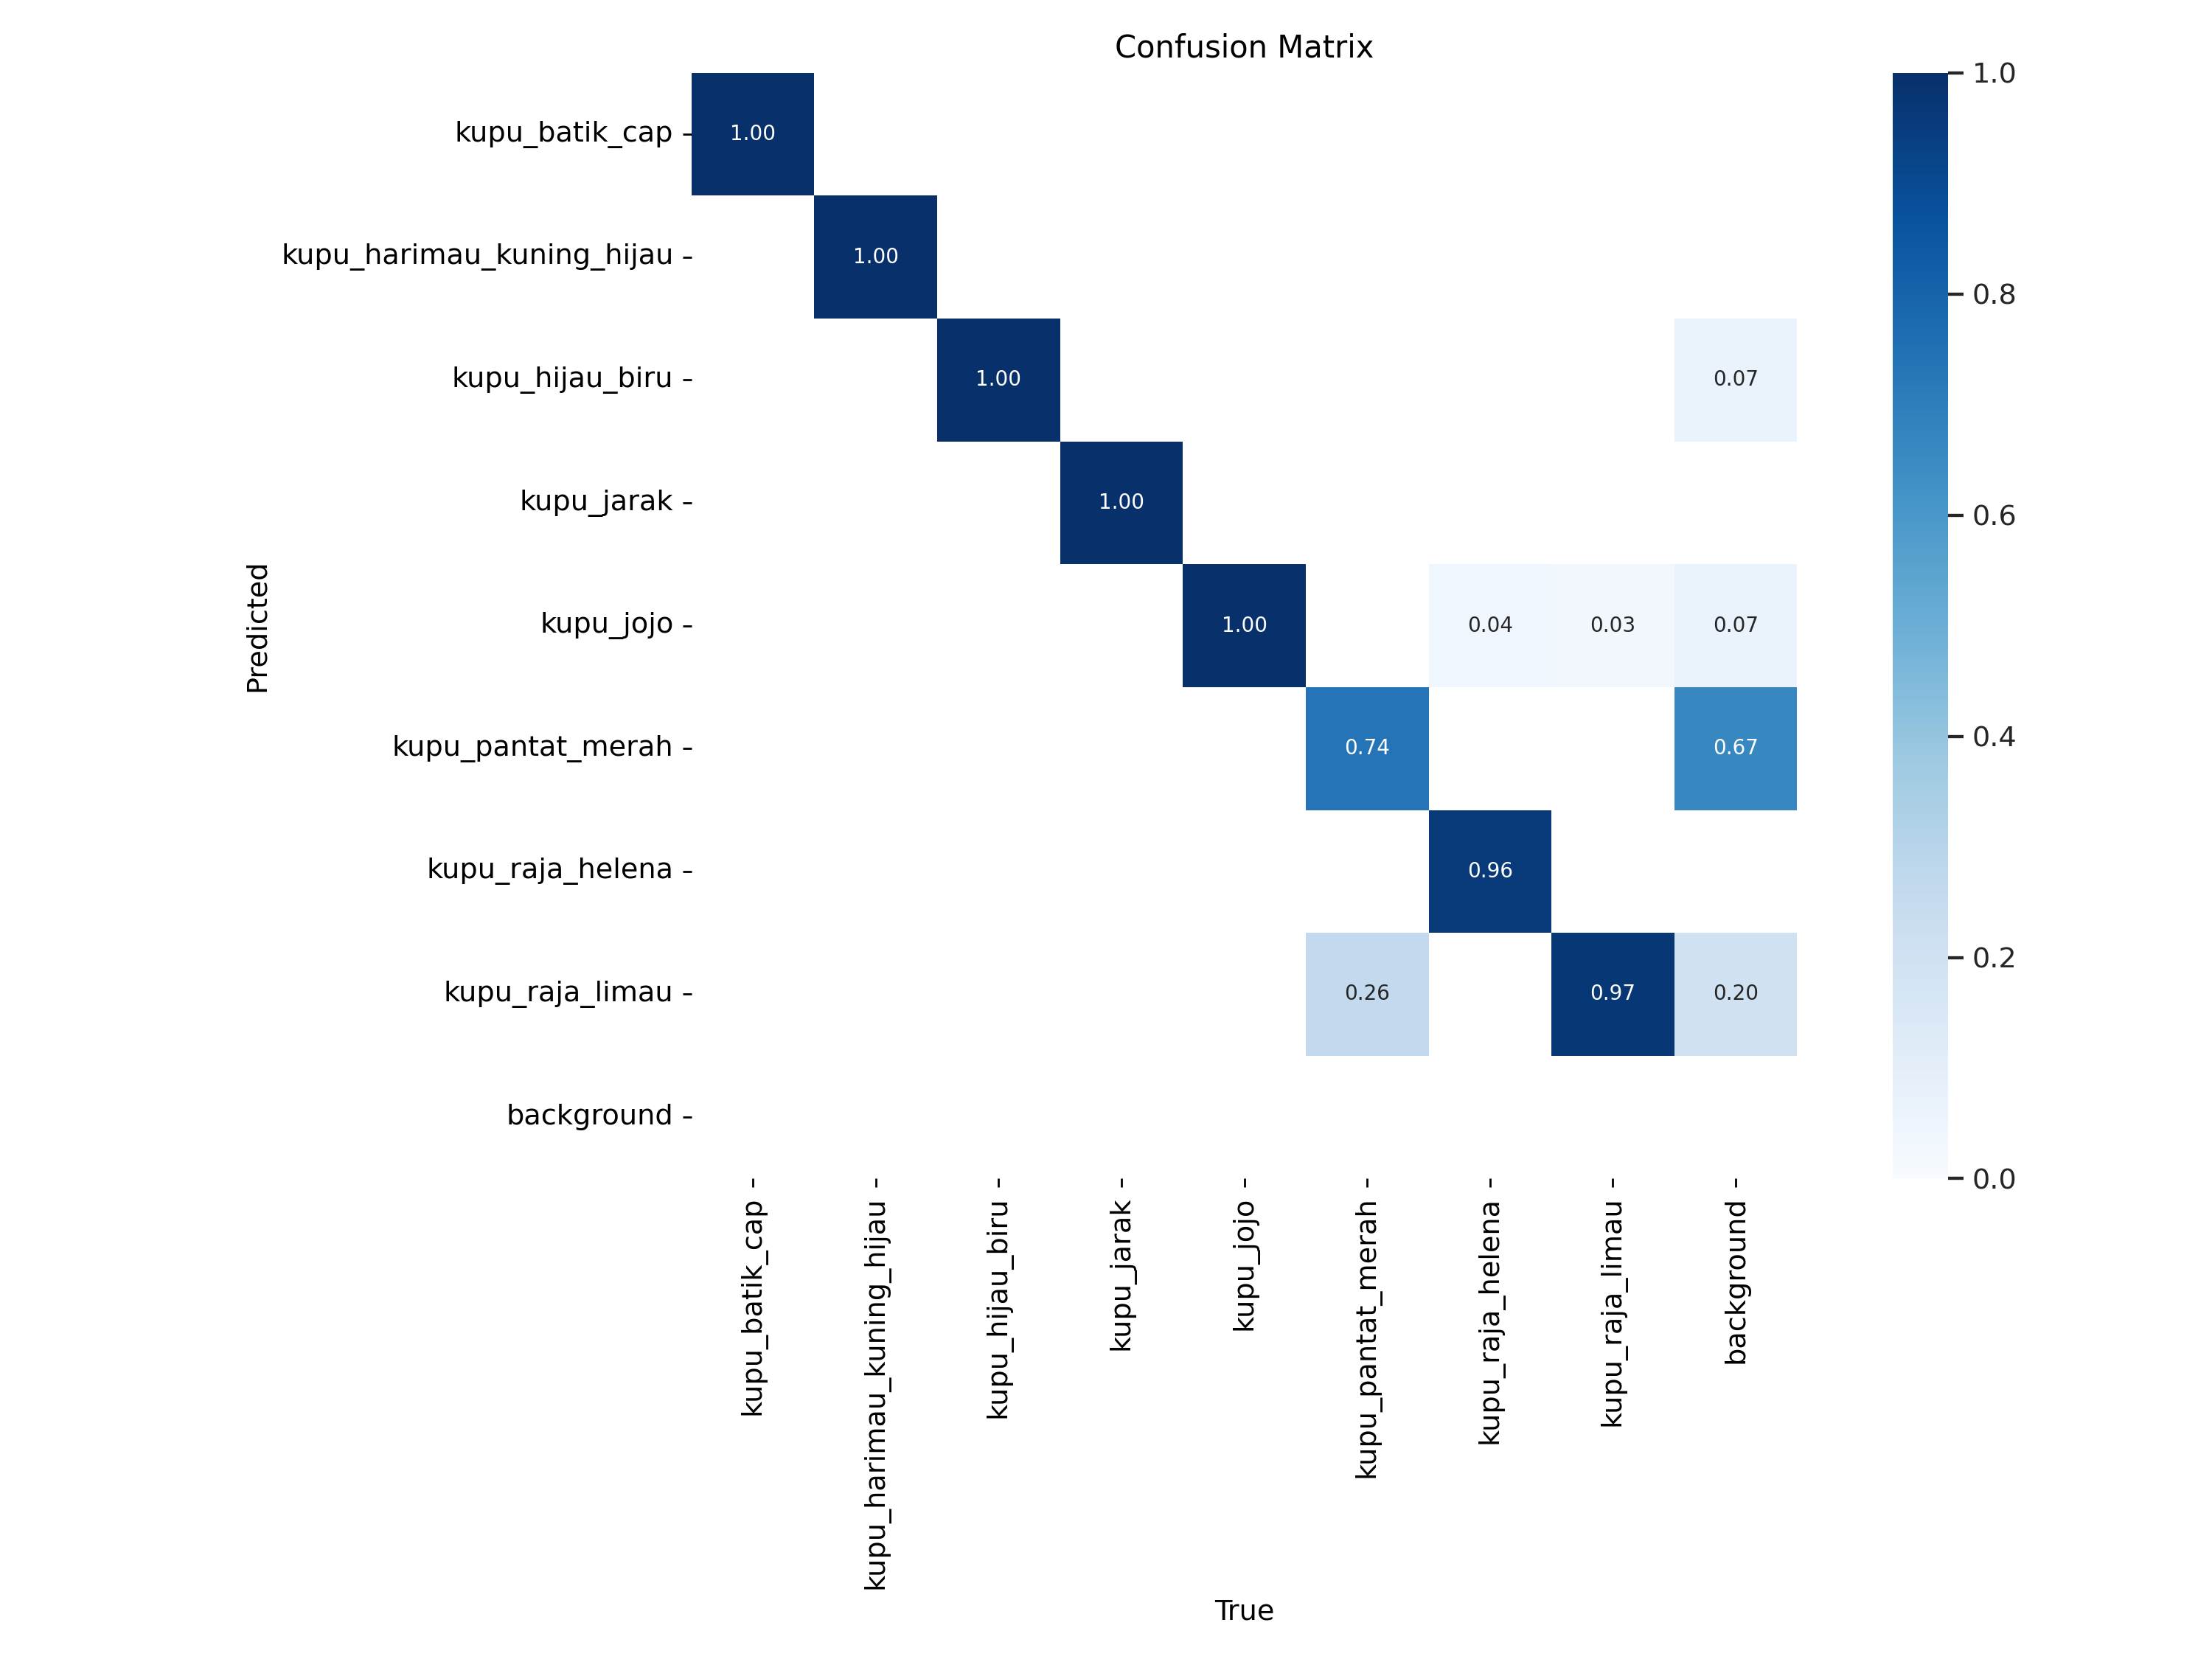

In [16]:
Image(filename = '/content/runs/yolov5_detect2/confusion_matrix.png')

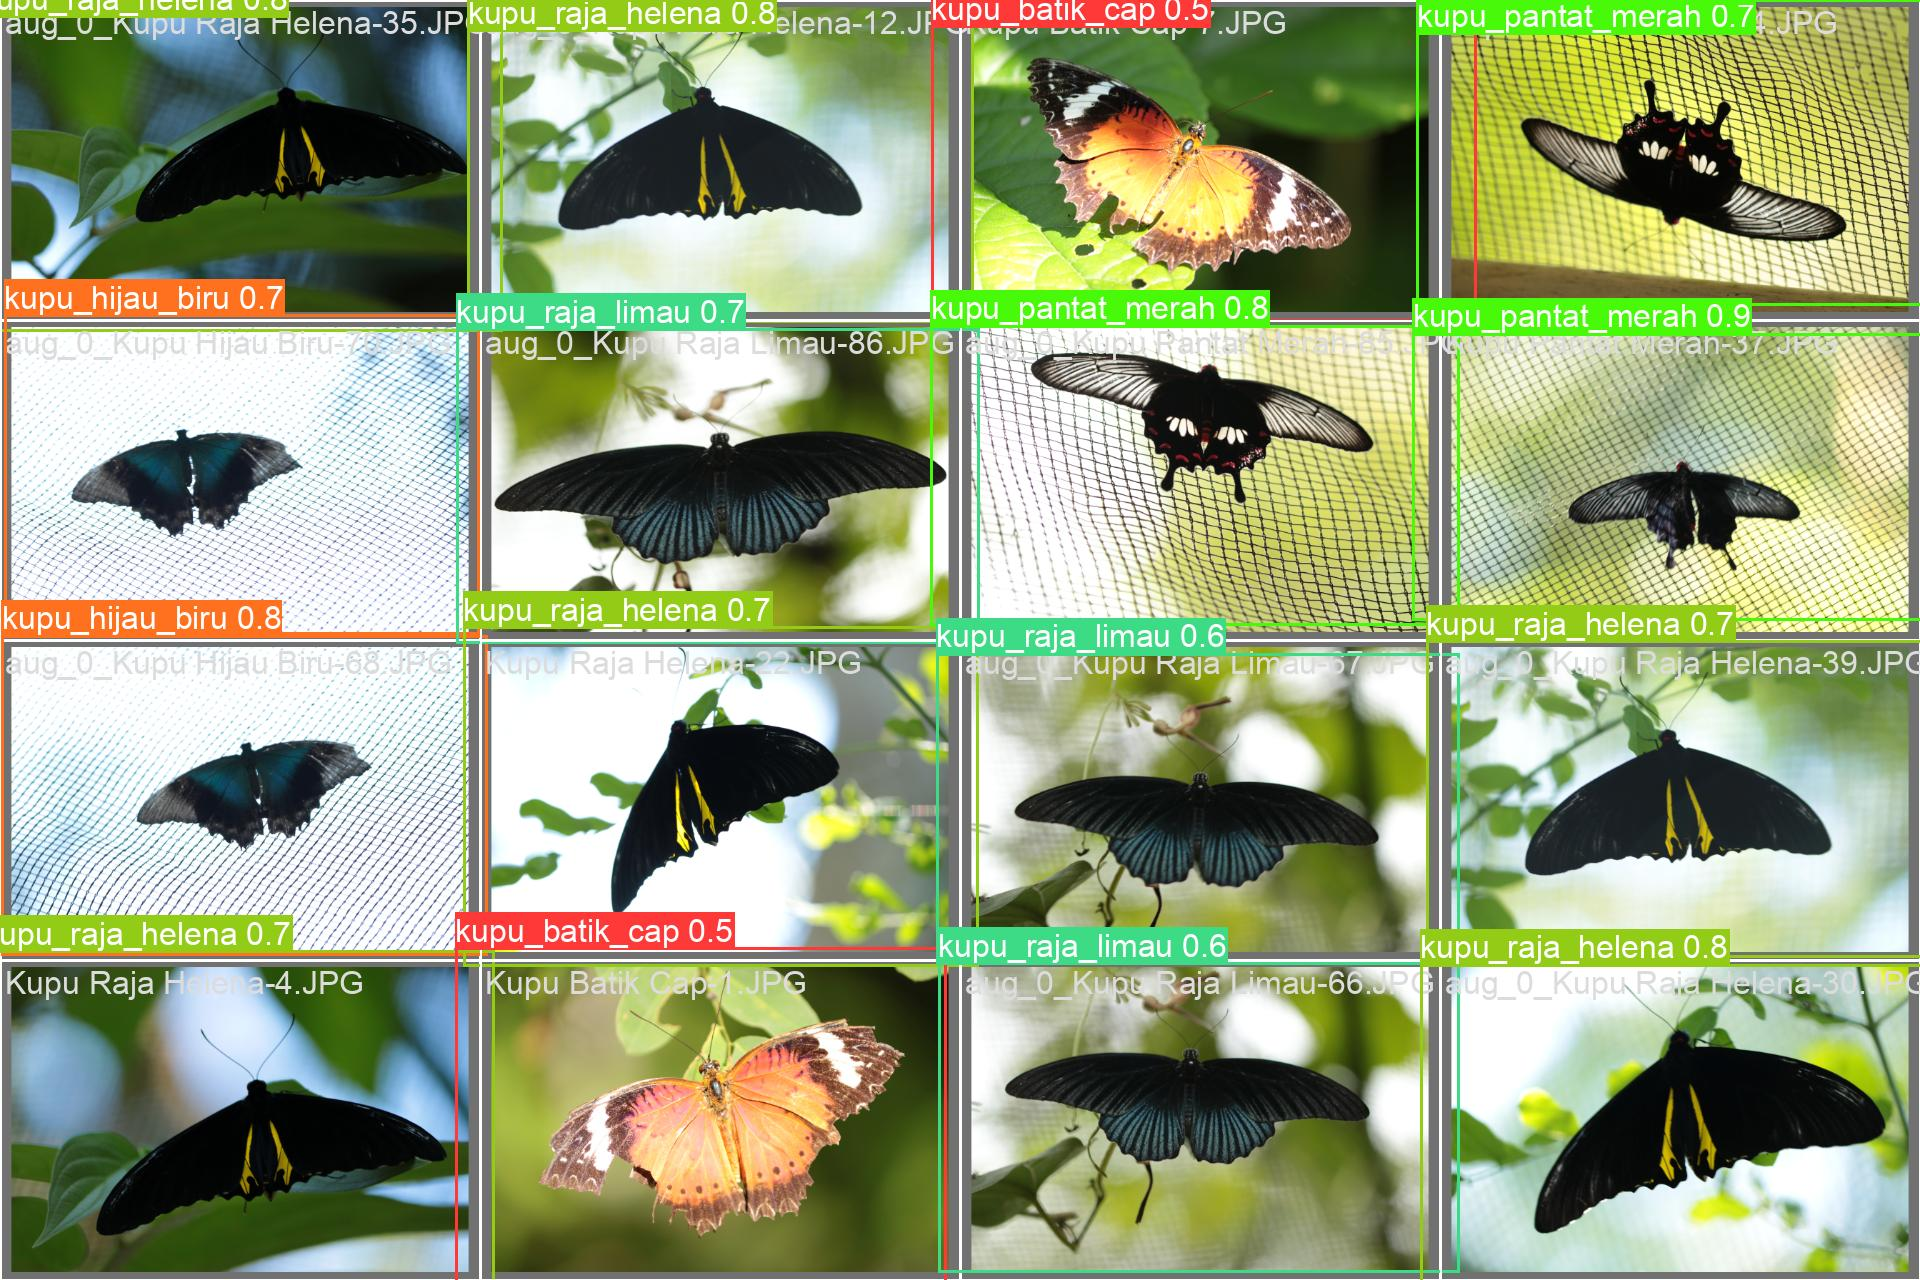

In [18]:
Image(filename = '/content/runs/yolov5_detect2/val_batch1_pred.jpg')